<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Предобработка данных</a></span></li></ul></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия-до-преобразований" data-toc-modified-id="Линейная-регрессия-до-преобразований-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная регрессия до преобразований</a></span></li><li><span><a href="#Линейная-регрессия-после-преобразований" data-toc-modified-id="Линейная-регрессия-после-преобразований-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Линейная регрессия после преобразований</a></span></li></ul></li></ul></div>

# Защита персональных данных клиентов

Нам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обосновать корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. 

# Цель проекта

Необходимо разработать алгоритм защиты персональных данных таким образом, чтобы при его применении качество модели машинного обучения не ухудшилось.

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from numpy import linalg
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
RANDOM_STATE = 42

In [2]:
try:
    df = pd.read_csv('insurance.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/insurance.csv')

In [3]:
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


**Изменим название столбцов**

In [4]:
df.columns

Index(['Пол', 'Возраст', 'Зарплата', 'Члены семьи', 'Страховые выплаты'], dtype='object')

In [5]:
df.columns = ['sex', 'age', 'salary', 'family_members', 'insurance_payment']

### Предобработка данных

**Проверим пропуски**

In [6]:
df.isna().mean()

sex                  0.0
age                  0.0
salary               0.0
family_members       0.0
insurance_payment    0.0
dtype: float64

In [7]:
df['insurance_payment'].unique()

array([0, 1, 2, 3, 5, 4], dtype=int64)

**Классы не сбалансированны, сильно отличаются!**

Text(0.5, 1.0, 'Количество классов в target')

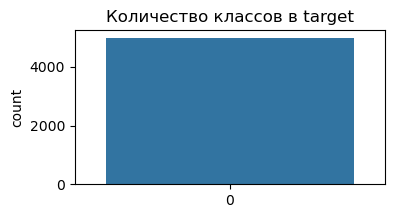

In [8]:
plt.figure(figsize=(4, 2))
sns.countplot(df['insurance_payment'])
plt.title('Количество классов в target')

**Проверим на дубликаты и удалим их**

In [9]:
df = df.drop_duplicates()
df.shape

(4847, 5)

Удалили 150 наблюдений

**Рассмотрим признак age**

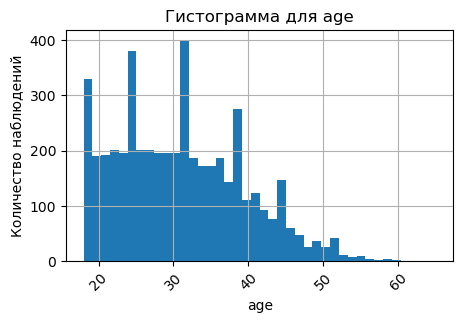

In [10]:
plt.figure(figsize=(5, 3))
df.age.hist(bins=40)
plt.xlabel('age')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма для age')
plt.xticks(rotation=45);

Посмотрим подробнее наблюдения больше 60 лет

In [11]:
df.query('age > 60')

,sex,age,salary,family_members,insurance_payment
228,1,65.0,39700.0,1,5
3907,1,61.0,39600.0,1,4
4019,0,62.0,14100.0,0,4


**Предположу, что это выбросы, удалю их**

In [12]:
df = df.drop(index=df.query('age > 60').index, axis=1)

**Рассмотрим подробнее признак salary** 

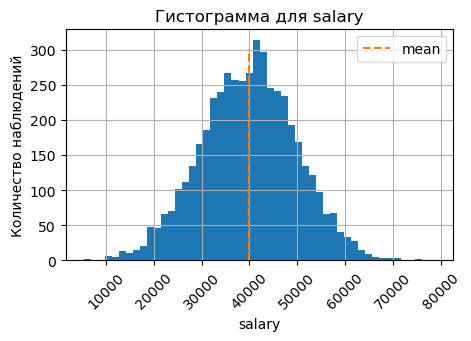

In [13]:
plt.figure(figsize=(5, 3))
df.salary.hist(bins=50)
plt.xlabel('salary')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма для salary')
plt.xticks(rotation=45)
plt.plot([df.salary.mean()]*df.salary.shape[0], np.linspace(0, 300, df.salary.shape[0]), '--', label='mean')
plt.legend();

**Удалим наблюдения, которые меньше 9к и больше 72к, предположу, что это выбросы.**

In [14]:
df.query('salary < 72000 & salary > 9000')

,sex,age,salary,family_members,insurance_payment
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


In [15]:
df = df.drop(index=df.query('salary > 72000 & salary < 9000').index, axis=1)

In [16]:
df.shape

(4844, 5)

Предобработка окончена, теперь в нашем распоряжении 4844 обучающих объектов.


<div class="alert alert-info">
    <br /> 
    <font size="3", color = "black">
<br /> В данном проекте я не разбивал данные на train и test, поскольку для демонстрации алгоритма выбрал прогнать его на всех данных.

## Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = X\cdot w
$$

Задача обучения:

$$
w = \arg\min_w MSE(X\cdot w, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** Нет, **качество** линейной регрессии, при умножении признаков на обратимую матрицу **не изменится!**

**Обоснование:** 

Положим, что матрица P является обратимой,  причем **проверим, что она невырожденная**. Затем запишем новую формулу предсказаний:

$$a = X\cdot P\cdot w$$

Теперь, задачу обучения сводится к 

$$
w = \arg\min_w MSE(X\cdot P \cdot w, a)
$$

А формула обучения примет вид:


$$
w = ((X\cdot P)^T\cdot (X\cdot P))^{-1} (X\cdot P)^T \cdot a
$$

Тогда, если $X\cdot P$ не меняет качество предсказаний, то $a = X\cdot P \cdot ((X\cdot P)^T\cdot (X\cdot P))^{-1} (X\cdot P)^T \cdot a$. И если это так, то после сокращений у нас должно остаться тождество a = a!

$$
a^{'} = X\cdot P \cdot ((X\cdot P)^T\cdot (X\cdot P))^{-1} (X\cdot P)^T \cdot a \Rightarrow 
$$


$$
Учтем,\ что\ матрица\ X\ не\ является\ квадратной\, значит\ для\ нее\ не\ существует\ обратной\ матрицы,\ следовательно,\ для\ X\ и\ X^{T}\ не\ существует\ обратных\ матриц.\ Тогда,\ раскроем\ скобки\ по\ свойству\ обратной\ матрицы:
$$

$$
\Rightarrow XP \cdot (P^{T}X^{T}XP)^{-1} \cdot (XP)^{T}\cdot a \Rightarrow
$$

$$
\Rightarrow XP \cdot ((P^{T}X^{T}X)P)^{-1} \cdot P^{T}X^{T}\cdot a \Rightarrow
$$

$$
\Rightarrow XPP^{-1} \cdot (P^{T}X^{T}X)^{-1}\cdot  P^{T}X^{T}\cdot a \Rightarrow
$$

$$
\Rightarrow X\cdot E \cdot (X^{T}X)^{-1} \cdot (P^{T})^{-1} \cdot P^{T}X^{T}\cdot a \Rightarrow
$$

$$
\Rightarrow X\cdot E \cdot (X^{T}X)^{-1} \cdot E \cdot X^{T}\cdot a \Rightarrow
$$

$$
\Rightarrow X \cdot (X^{T}X)^{-1}\cdot X^{T}\cdot a \Rightarrow
$$

$$
\Rightarrow a^{'} = a.
$$

**Таким образом, мы показали, что умножение матрицы признаков на обратимую матрицу не меняет предсказание модели.**

## Алгоритм преобразования

**Алгоритм**

В качестве алгоритма преобразования я предлагаю следующую композицию:

1) Столбец salary умножим на 0.3 и прибавим 4000

2) Столбец age умножим на 12

3) Применение стандратизации данных (это необходимо для масштабирования признаков и улучшения предсказательной способности модели).

4) Генерация невырожденной матрицы (определитель не равен 0). Размер матрицы обосную ниже.




**Обоснование**

Первые 2 операции не повлияют на качество модели, поскольку мы применяем эти операции ко всему столбцу в матрице.

Стандартизация данных также поможет немного "скрыть" данные.

Если в линейной регрессии не активировать параметр fit_intercept=True, то необходимо будет добавлять столбец с единицами (bias) вручную. Изначально матрица признаков имеет размерность $X_{(5000, 4)}$, а вектор столбец $y$ имеет размерность $y_{(5000, 1)}$  $\Rightarrow$ но поскольку мы bias учитываем как вектор из единиц и добавляем его в матрицу фичей X, то теперь размерность $X_{(5000, 5)}$, а следовательно, размерность матрицы весов $w_{(5, 5)}$. 

**В нашей задаче я попробую 2 способа, добавлю вектор-столбец из единиц вручную, а затем попробую использовать параметр fit_intecept=True и сравню результаты.**

## Проверка алгоритма

Разбиваем данные на фичи и таргет 

In [17]:
X = df.drop(['insurance_payment'], axis=1)
y = df['insurance_payment']

In [18]:
feature_scaler = ['age', 'salary', 'family_members']

**Для проверки случая c добавлением вектора-столбца из единиц добавим в набор bias**

In [19]:
X_bias = X.copy(deep=True)

In [20]:
X_bias['bias'] = 1

In [21]:
X_bias

,sex,age,salary,family_members,bias
0,1,41.0,49600.0,1,1
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,1
3,0,21.0,41700.0,2,1
4,1,28.0,26100.0,0,1
...,...,...,...,...,...
4995,0,28.0,35700.0,2,1
4996,0,34.0,52400.0,1,1
4997,0,20.0,33900.0,2,1
4998,1,22.0,32700.0,3,1


### Линейная регрессия до преобразований

In [22]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, feature_scaler)
        ])

pipe = Pipeline(steps=[
    ('preprocessor_fearure', preprocessor),
    ('model', LinearRegression())
])

In [23]:
pipe

Pipeline(steps=[('preprocessor_fearure',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'salary',
                                                   'family_members'])])),
                ('model', LinearRegression())])

In [24]:
pipe.fit(X, y)

Pipeline(steps=[('preprocessor_fearure',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'salary',
                                                   'family_members'])])),
                ('model', LinearRegression())])

In [25]:
pipe.predict(X)

array([ 0.50566856,  0.68222985,  0.09495922, ..., -0.24994176,
       -0.19280017,  0.04628029])

In [26]:
y

0       0
1       1
2       0
3       0
4       0
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: insurance_payment, Length: 4844, dtype: int64

In [27]:
print(f'R2-score: {r2_score(y, pipe.predict(X))}')

R2-score: 0.428134049772389


### Линейная регрессия после преобразований

Выволним первые 2 шага алгоритма:

1) Столбец salary умножим на 0.3 и прибавим 4000

2) Столбец age умножим на 12


In [28]:
X['salary'] = X['salary']*0.3 + 4000

In [29]:
X['age'] = X['age']*12

**Зафиксируем случайность и сгенерируем матрицу размером (4, 4). Поскольку нам нужна квадратная матрица, размерность которой равна количеству признаков**

In [30]:

np.random.seed(RANDOM_STATE)
P = np.random.randn(4, 4)

np.linalg.det(P)

-1.863820081188515

**Видим, что матрица невырожденная, поскольку определитель равен 0, следовательно для нее существует обратная матрица**

Вычислим обратную матрицу к матрице P

In [31]:
P_inv = np.linalg.inv(P)
P_inv

array([[-0.33124857, -1.0333483 , -2.21070923, -0.47651024],
       [ 0.12864778, -0.47781825,  0.15271687, -0.43017975],
       [-0.51338817,  0.33588835, -0.8347692 , -0.24072429],
       [ 0.99462192,  0.15079316,  1.08985145,  0.21872535]])

**Проведем преобразование** и запишем новые значения в DataFrame

In [32]:
X_p = pd.DataFrame(data=(X.values @ P_inv), columns=X.columns)

In [33]:
X_p

,sex,age,salary,family_members
0,-9628.810532,6105.602962,-15686.426630,-4756.780863
1,-7834.169593,4909.075748,-12770.056097,-3944.394600
2,-5243.128704,3293.369280,-8544.977276,-2629.162765
3,-8441.630170,5425.408088,-13741.375117,-4082.325915
4,-6030.487623,3811.978930,-9826.217462,-2992.785286
...,...,...,...,...
4839,-7506.725055,4780.672320,-12225.962342,-3685.157287
4840,-10070.531758,6428.919259,-16398.250264,-4922.377660
4841,-7241.845630,4645.163162,-11789.847794,-3513.868914
4842,-7053.274970,4511.893162,-11486.786535,-3437.790267


In [34]:
columns = Pipeline(steps=[
    ('scaler', StandardScaler())
])


preprocessor = ColumnTransformer(transformers=[
    ('scaler', columns, feature_scaler)
])

In [35]:
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [36]:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'salary',
                                                   'family_members'])])),
                ('model', LinearRegression())])

In [37]:
pipe.fit(X_p, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'salary',
                                                   'family_members'])])),
                ('model', LinearRegression())])

In [38]:
pipe.predict(X_p)

array([ 0.5141532 ,  0.67102936,  0.07606692, ..., -0.25394231,
       -0.16983313,  0.05458516])

In [39]:
print(f'Качество модели R2-score: {r2_score(y, pipe.predict(X_p))}')

Качество модели R2-score: 0.4277366372966601


**Качество модели не изменилось, следовательно, алгоритм корректен!**

# Вывод

В данном проекте мы применили алгоритм, основанный на обратимой матрице. Провели предобработку данных и математически показали, что применный нами алгоритм не изменяет качество.

Примененный алгоритм по сокрытию персональных данных отрабатывает корректно, качество модели до него и после остается на одном уровне.